In [1]:
!pip install transformers
!pip install sentencepiece
!pip install accelerate
!pip install salesforce-lavis
!pip install datasets
!pip install evaluate
!pip install rouge_score

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
import pandas as pd
import numpy as np
import random
from PIL import Image
import torch
from lavis.models import load_model_and_preprocess
from transformers import T5Tokenizer, T5ForConditionalGeneration
import evaluate
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
file_path_questions = "data/questions/v2_OpenEnded_mscoco_train2014_questions.json"
file_path_answers = "data/answers/v2_mscoco_train2014_annotations.json"
file_path_explain = "data/VQA-X/train_exp_anno.json"

def load_dataset(file_path_questions, file_path_answers, file_path_explain):
    
    df_questions = pd.read_json(file_path_questions, lines=True)
    df_answers = pd.read_json(file_path_answers, lines=True)
    df_explain = pd.read_json(file_path_explain, lines=True)
    
    df_explain = df_explain.transpose().copy()
    df_explain.reset_index(inplace = True)
    df_explain.rename(columns = {"index": "question_id",0:"explainations"}, inplace = True)
    df_explain["explainations"] = df_explain.apply(lambda row: row["explainations"][0], axis = 1)
    
    return df_questions, df_answers, df_explain

def make_final_questions_df(df_questions):
    
    df_question = df_questions['questions'].iloc[0].copy()
    
    image_id = []
    question = []
    question_id = []
    for i in df_question:
        x = list(i.values())
        image_id.append(x[0])
        question.append(x[1])
        question_id.append(x[2])
        
    df_question = pd.DataFrame({
        "image_id": image_id,
        "question": question,
        "question_id": question_id
    })
    
    return df_question

def make_final_answers_df(df_answers):
    
    df_answers = df_answers['annotations'].iloc[0]
    
    image_id = []
    answer = []
    question_id = []
    question_type = []
    for i in df_answers:
        x = list(i.values())
        image_id.append(x[3])
        question_type.append(x[0])
        answer.append(x[1])
        question_id.append(x[5])
        
    df_answer = pd.DataFrame({
        "image_id": image_id,
        "question_type": question_type,
        "question_id": question_id,
        "answer": answer
    })
    
    return df_answer



df_questions, df_answers, df_explain = load_dataset(file_path_questions, file_path_answers, file_path_explain)
df_question = make_final_questions_df(df_questions)
df_answer= make_final_answers_df(df_answers)

This gives us question, answer and explain df

In [3]:
num_samples = 100

def make_final_df(df_question,df_answer,df_explain):
    
    final_df = pd.merge(pd.merge(df_question, df_answer, how = "outer", on = "question_id"), 
                        df_explain, how = "outer", on = "question_id").dropna(axis = 0)
    final_df.drop(columns = ["image_id_y"])
    final_df.rename(columns = {"image_id_x": "image_id"}, inplace = True)
    
    return final_df

def select_sample_dataset(num_samples, final_df):
    
    random_samples = final_df.sample(n=num_samples, random_state=42)
    random_samples_df = pd.DataFrame(random_samples)
    
    return random_samples_df

def save_file(file_name,df):
    df.to_csv(file_name)
    
final_df = make_final_df(df_question,df_answer,df_explain)
df = select_sample_dataset(num_samples, final_df)
save_file('final_dataset',df)

In [4]:
def find_image_list(df):
    
    image_list = []
    for index, rows in df.iterrows():
        string = "data/images/train2014/COCO_train2014_"+"".join([str(0)]*(12 - len(str(rows["image_id"]))))+str(rows["image_id"])+".jpg"
        Image_data = Image.open(string).convert("RGB")
        image_list.append(Image_data)
        
    return image_list


In [36]:
def load_blip_2(name="blip2_t5", model_type="caption_coco_flant5xl"):
    
    model, vis_processors, _ = load_model_and_preprocess(
        name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True)
    
    return model, vis_processors


def generate_captions(model, vis_processors, df):

    image_list = find_image_list(df)
    df["image"] = image_list
    captions = []

    for i in tqdm(range(len(df))):
        image = vis_processors["eval"](df["image"].iloc[i]).unsqueeze(0)
        x = model.generate({"image": image, "prompt": "Give Caption for this Image along with details on objects specifie"})
        captions.append(x)
        
    df.drop(columns = ["image","image_id_y"], inplace = True)
    df["captions_BLIP"] = captions
    
    return df

def load_flan_model():
    
    tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xxl")
    model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xxl", device_map="auto")
    
    return tokenizer,model

def find_flan_output_answers(model, tokenizer, df):


    answer_flan = []

    for idx in tqdm(range(len(df))):
        prompt = f"""Given the caption, provide an answer for the question provided below.
                Question: '''{df["question"].iloc[idx]}'''
                Caption: '''{df["captions_BLIP"].iloc[idx]}'''
             """
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        outputs = model.generate(input_ids)
        answer_flan.append(tokenizer.decode(outputs[0]))
        
    cleaned_flan_answers = [sentence.replace("<pad>", "").replace("</s>", "") for sentence in answer_flan]
        
    df["answer_flan"] = cleaned_flan_answers
    
    return df

#this is explanations based on actual answers
def find_flan_output_explainations(model, tokenizer, df):
    
    explain_flan = []

    for idx in tqdm(range(len(df))):
        prompt = f"""Based on the following data provided, answer the following question: "Why is that? Give an explanation/rationale for the answer provided."
                Question: '''{df["question"].iloc[idx]}'''
                Answer: '''{df["answer"].iloc[idx]}'''
                Caption: '''{df["captions_BLIP"].iloc[idx]}'''
             """
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        outputs = model.generate(input_ids)
        explain_flan.append(tokenizer.decode(outputs[0]))
        
    cleaned_flan_explain = [sentence.replace("<pad>", "").replace("</s>", "") for sentence in explain_flan]

    df["explain_flan"] = cleaned_flan_explain
    
    return df

#this is explanations based on generated answers
def find_flan_output_explainations_gen(model, tokenizer, df):
    
    explain_flan = []

    for idx in tqdm(range(len(df))):
        prompt = f"""Based on the following data provided, answer the following question: "Why is that? Give an explanation/rationale for the answer provided."
                Question: '''{df["question"].iloc[idx]}'''
                Answer: '''{df["answer_flan"].iloc[idx]}'''
                Caption: '''{df["captions_BLIP"].iloc[idx]}'''
             """
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        outputs = model.generate(input_ids)
        explain_flan.append(tokenizer.decode(outputs[0]))
        
    cleaned_flan_explain = [sentence.replace("<pad>", "").replace("</s>", "") for sentence in explain_flan]

    df["explain_flan_gen"] = cleaned_flan_explain
    
    return df

In [ ]:
model_blip, vis_processors = load_blip_2(name="blip2_t5", model_type="caption_coco_flant5xl")
df = generate_captions(model_blip, vis_processors, df)

In [16]:
df.drop(columns = ["image","image_id_y"], inplace = True)

In [ ]:
tokenizer, model_flan = load_flan_model()
df = find_flan_output_answers(model_flan, tokenizer, df)

In [14]:
df = find_flan_output_explainations(model_flan, tokenizer, df)

  0%|          | 0/100 [00:00<?, ?it/s]/home/users/sdash/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/users/sdash/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1359: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%

In [37]:
df = find_flan_output_explainations_gen(model_flan, tokenizer, df)

  0%|          | 0/100 [00:00<?, ?it/s]/home/users/sdash/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/users/sdash/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1359: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
100%

In [22]:
def convert_to_string(lst):
    return ' '.join(lst)

df['captions_BLIP'] = df['captions_BLIP'].apply(convert_to_string)

In [24]:
save_file('final_dataset.csv',df)

In [30]:
def metric_computation(prediction, references, metric):
    
    metric = evaluate.load(metric)
    result = metric.compute(predictions=prediction,
                         references=references)
    
    return result

In [56]:
meteor = []
rouge = {}

In [57]:
references = list(df["answer"])
prediction = list(df["answer_flan"])

meteor_score = metric_computation(prediction, references, metric = 'meteor')["meteor"]
rouge_score = list(metric_computation(prediction, references, metric = 'rouge').values())

meteor.append(meteor_score)
rouge["answer_flan"] = rouge_score

print("The METEOR and ROUGE scores for the answer prediction model")
print("METEOR score:", meteor_score)
print("ROUGE score:", rouge_score)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The METEOR and ROUGE scores for the answer prediction model
METEOR score: 0.3657103313353314
ROUGE score: [0.7033333333333333, 0.01, 0.7066666666666666, 0.7086666666666668]


In [58]:
references = list(df["explainations"])
prediction = list(df["explain_flan"])

meteor_score = metric_computation(prediction, references, metric = 'meteor')["meteor"]
rouge_score = list(metric_computation(prediction, references, metric = 'rouge').values())

meteor.append(meteor_score)
rouge["explain_flan"] = rouge_score

print("""The METEOR and ROUGE scores for the explanation prediction model 
where ground truth answers where used to generate explnanation.""")
print("METEOR score:", meteor_score)
print("ROUGE score:", rouge_score)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The METEOR and ROUGE scores for the explanation prediction model 
where ground truth answers where used to generate explnanation.
METEOR score: 0.20356683700192124
ROUGE score: [0.22674923675003583, 0.05448260837889321, 0.20541505519327224, 0.20410243543510964]


In [59]:
references = list(df["explainations"])
prediction = list(df["explain_flan_gen"])

meteor_score = metric_computation(prediction, references, metric = 'meteor')["meteor"]
rouge_score = list(metric_computation(prediction, references, metric = 'rouge').values())

meteor.append(meteor_score)
rouge["explain_flan_gen"] = rouge_score

print("""The METEOR and ROUGE scores for the explanation prediction model
where answers from flan_xxl model where used to generate explnanation""")
print("METEOR score:", meteor_score)
print("ROUGE score:", rouge_score)

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/sdash/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


The METEOR and ROUGE scores for the explanation prediction model
where answers from flan_xxl model where used to generate explnanation
METEOR score: 0.21048486233496252
ROUGE score: [0.23388098006374347, 0.05361453586832844, 0.21123889250883116, 0.21105928809428592]


In [40]:
save_file('final_dataset_with_gen.csv',df)

Text(0.5, 1.0, 'Meteor scores hist plot')

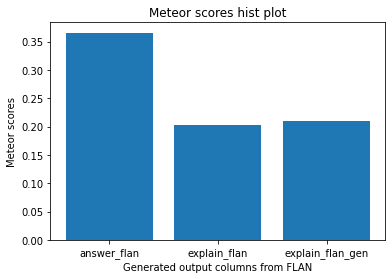

In [64]:
columns = ["answer_flan", "explain_flan","explain_flan_gen"]

plt.bar(columns, meteor)
plt.xlabel("Generated output columns from FLAN")
plt.ylabel("Meteor scores")
plt.title("Meteor scores hist plot")

Text(0.5, 1.0, 'Meteor scores hist plot')

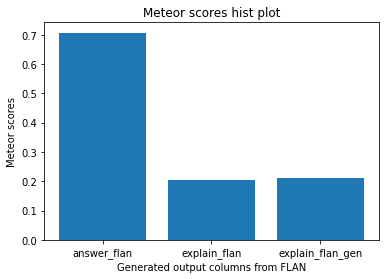

In [83]:
columns = ["answer_flan", "explain_flan","explain_flan_gen"]
rouge_ = []
for i in range(len(list(rouge.values()))):
    rouge_.append(list(rouge.values())[i][2])
plt.bar(columns, rouge_)
plt.xlabel("Generated output columns from FLAN")
plt.ylabel("Meteor scores")
plt.title("Meteor scores hist plot")